# User Question 002

A new user asks:
> We have the notion of a list of electrodes, which would fit nicely into an Electrode table, but then data are taken from groups of electrodes at a time (e.g. a tetrode, a 32 channel shank of a polymer probe, etc). Neurodata Without Borders (nwb.org) handles that with a table that indicates, for every data object, which electrodes were included.  How are these sorts of references possible in DataJoint? 

Similar designs have been deployed by many DataJoint-based ephys schemas. 
For example, here is on from the International Brain Lab https://github.com/int-brain-lab/IBL-pipeline/blob/master/ibl_pipeline/ephys.py
and another from the Mesoscale Activity Project https://github.com/mesoscale-activity-map/map-ephys/blob/master/pipeline/ephys.py
These schemas were designed to closely match NWB conventions and names.

Let's define a minimal example:

First, let's work with an existing schema defining experiment sessions and we will add ephys probes in our new schema within this notebook. 

Imagine that the schema designed in [User Question 001](Question-001.ipynb) can is defined in a module called `experiment.py`. Then we would be able to import it as 

```python
import experiment
```

and access all its tables.

However, that schema was defined in a notebook. DataJoint provides function `dj.create_virtual_module` to mimic importing a virtual module by reconstructing it from the tables in the database.

In [11]:
import datajoint as dj
experiment = dj.create_virtual_module('experiment', 'test_question001')

We can view the schema from [User Question 1](Question-001.ipynb), and access any of its data:

First, let's define the `User` set to contain all the lab members who will conduct experiments and we will populate it with a few names.

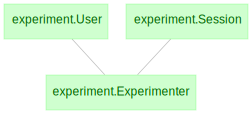

In [10]:
dj.Diagram(experiment)

In [12]:
experiment.Session()

session session number,session_date
1,2018-04-09
2,2019-02-07
3,2019-03-31


Now let's define a new schema for working with electrophysiology probes for the experiment session.

In [15]:
schema = dj.schema('test_question002')

Let's define the `Probe` set to define various available probes. We choose to define as a lookup table, meaning that its contents is fairly static and is populated from the `contents` property of its class.

In [18]:
@schema
class Probe(dj.Lookup):
    definition = """
    # Ephys probe
    probe_part_no  :  varchar(20)
    ---
    probe_type : varchar(32)
    probe_comment :  varchar(4000)
    """
    contents = [
        ('15131808323', 'neuropixels probe O3', ''),
        ('H-194', 'janelia2x32', '')
    ]

Now let's define the `ElectrodeGroup` for a given session. These are electrodes on a probe. Multiple groups can be used in a single session. Hence, we add the `electrode_group` attribute to the primary key. We add `Probe` as a secondary attribute. We then add the `Electrode` set as a [part table](https://docs.datajoint.io/python/computation/03-master-part.html) of `ElectrodeGroup`.

In [19]:
@schema
class ElectrodeGroup(dj.Manual):
    definition = """
    # Electrode
    -> experiment.Session
    electrode_group : tinyint # Electrode_group is like the probe
    ---
    -> Probe
    """

    class Electrode(dj.Part):
        definition = """
        -> master
        electrode : smallint # sites on the electrode
        """

Here is the entire pipeline with both schemas:

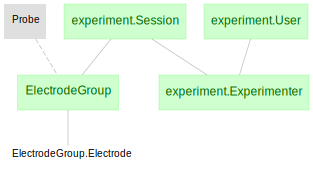

In [20]:
dj.Diagram(schema) + dj.Diagram(experiment)

Let's populate an electrode group for Session 1 with 32 electrodes

In [24]:
key = dict(session=2, electrode_group=1)
ElectrodeGroup.insert1(dict(key, probe_part_no='H-194'))
ElectrodeGroup.Electrode.insert(dict(key, electrode=i) for i in range(32))

Here is the result:

In [26]:
ElectrodeGroup * ElectrodeGroup.Electrode & key

session session number,electrode_group Electrode_group is like the probe,electrode sites on the electrode,probe_part_no
2,1,0,H-194
2,1,1,H-194
2,1,2,H-194
2,1,3,H-194
2,1,4,H-194
2,1,5,H-194
2,1,6,H-194


Have fun with DataJoint!